In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2024-08-23 10:58:51.069253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 10:58:52.732486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_dataset = train_datagen.flow_from_directory('../datasets/train', 
                                          target_size=(32,32),
                                          batch_size=32,
                                          class_mode="categorical")
test_dataset = test_datagen.flow_from_directory('../datasets/test', 
                                          target_size=(32,32),
                                          batch_size=32,
                                          class_mode="categorical")                                   

Found 9490 images belonging to 14 classes.
Found 4078 images belonging to 14 classes.


In [6]:
train_dataset.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'ba': 10,
 'gha': 11,
 'lu': 12,
 'pa': 13}

In [7]:
def dataset_to_numpy_array(generator):
    data = []
    labels = []
    for i in range(len(generator)):
        batch_data, batch_labels = generator[i]
        data.append(batch_data)
        labels.append(batch_labels)
    
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return data, labels

# Convert datasets to NumPy arrays
x_train_r, y_train_r = dataset_to_numpy_array(train_dataset)
x_test_r, y_test_r = dataset_to_numpy_array(test_dataset)

print(x_train_r.shape, y_train_r.shape)
print(x_test_r.shape, y_test_r.shape)

(9490, 32, 32, 3) (9490, 14)
(4078, 32, 32, 3) (4078, 14)


In [9]:
# # Define the CNN model
from tensorflow.keras.layers import Dropout, MaxPool2D


# model = Sequential()

# model.add(Conv2D(64, (3,3), input_shape=x_train_r.shape[1:]))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(64, (3,3))) 
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# # model.add(Conv2D(64, (3,3)))
# # model.add(Activation("relu"))
# # model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation("relu"))
# model.add(Dropout(0.4))  # Adding dropout with rate 0.4

# model.add(Dense(16))  # Assuming there are 13 classes
# model.add(Activation("softmax"))

model=Sequential([
    
    Conv2D(64,(3,3),input_shape=(x_train_r.shape[1:]),activation='relu'),
    MaxPool2D(),
    
    Conv2D(32,(2,2),activation='relu'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense(50,activation='relu'),
    Dropout(.4),
    Dense(44,activation='relu'),
    Dense(14,activation='softmax')
])
# model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        78,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 44)             │         2,244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │           630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,340 (356.80 KB)

 Trainable params: 91,340 (356.80 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(x_train_r, y_train_r, epochs=20, batch_size=128, 
                    validation_data=(x_test_r, y_test_r),
                    callbacks=[early_stopping])



Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.0814 - loss: 2.6421 - val_accuracy: 0.1064 - val_loss: 2.6285
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1129 - loss: 2.6271 - val_accuracy: 0.1050 - val_loss: 2.6154
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.1102 - loss: 2.6202 - val_accuracy: 0.1435 - val_loss: 2.6030
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.1228 - loss: 2.6069 - val_accuracy: 0.1059 - val_loss: 2.5862
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.1218 - loss: 2.5926 - val_accuracy: 0.1420 - val_loss: 2.5618
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.1486 - loss: 2.5703 - val_accuracy: 0.2185 - val_loss: 2.5238
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.1879 - loss: 2.5333 - val_accuracy: 0.2102 - val_loss: 2.4586
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.2132 - loss: 2.4593 - val_accuracy: 0.1555 - v

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6682 - loss: 1.2052
Test Loss: 1.2202926874160767
Test Accuracy: 0.6660127639770508


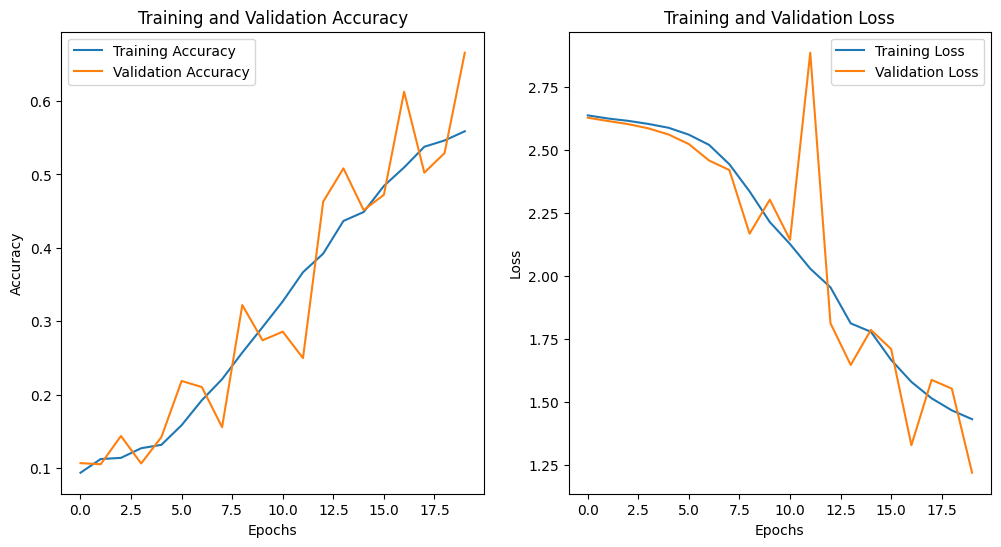

In [11]:
loss, accuracy = model.evaluate(x_test_r, y_test_r)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
# plt.savefig('train_test_copy.png')
plt.legend()

plt.show()

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


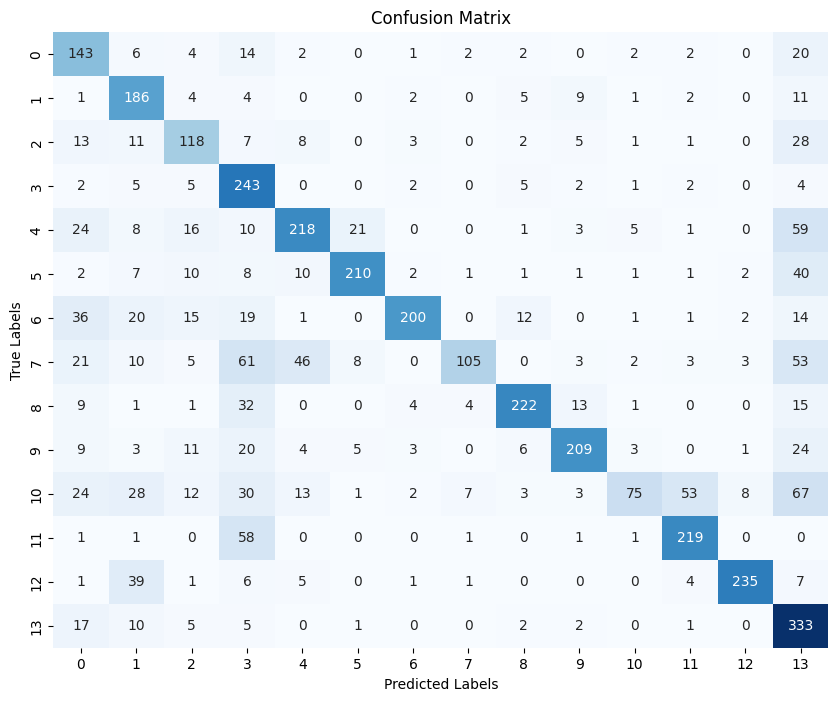

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the classes for the test data
y_pred = model.predict(x_test_r)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded test labels back to their original form
y_true = np.argmax(y_test_r, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# plt.savefig('confusion_matrix_copy.png')  # Save as PNG
plt.show()


In [1]:
model.save('sgd.keras')

NameError: name 'model' is not defined

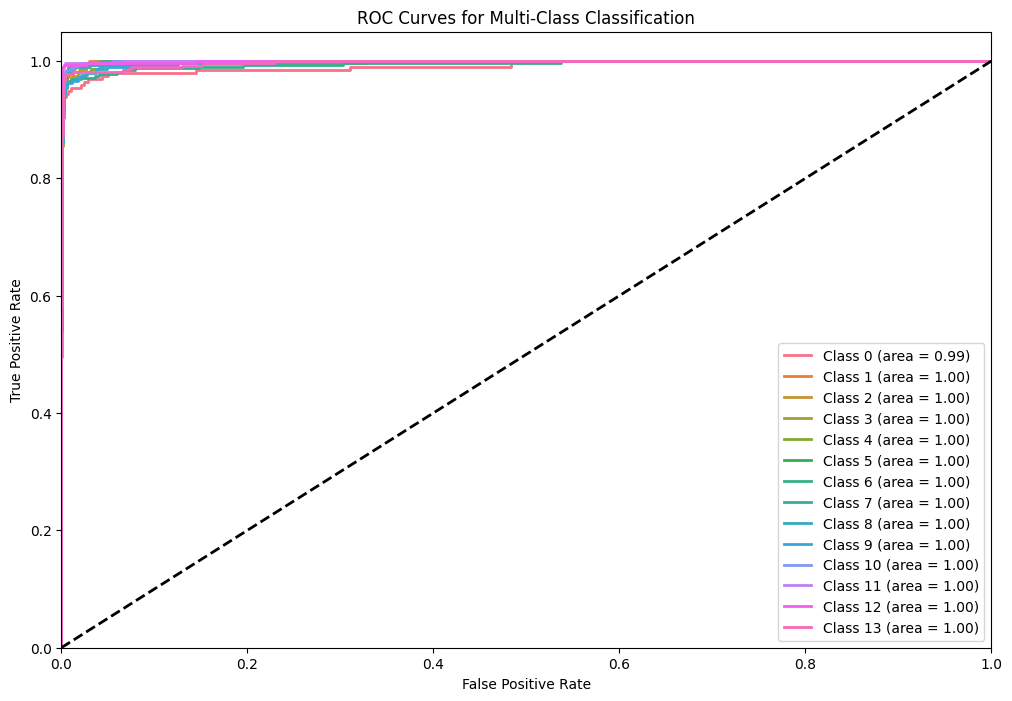

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_test_binarized = label_binarize(y_true, classes=np.arange(len(np.unique(y_true))))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", n_classes)

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right")
# plt.savefig('roc_curve.png')
plt.show()
